<a href="https://colab.research.google.com/github/gilles-rainer/Falcor44/blob/master/Copie_de_explore_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, maxdim, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-maxdim, maxdim, steps=sidelen * maxdim)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    return mgrid

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

    def laplace(y, x):
        grad = gradient(y, x)
        return divergence(grad, x)


    def divergence(y, x):
        div = 0.
        for i in range(y.shape[-1]):
            div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
        return div


    def gradient(y, x, grad_outputs=None):
        if grad_outputs is None:
            grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
        return grad

def load_texture(filanme, sidelength):
    # img = Image.fromarray(skimage.data.camera())
    img = Image.open(filename)
    # img = np.asarray(img)
    transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

torch.Size([3, 64, 64])
Step 0, Total loss 12.119117
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


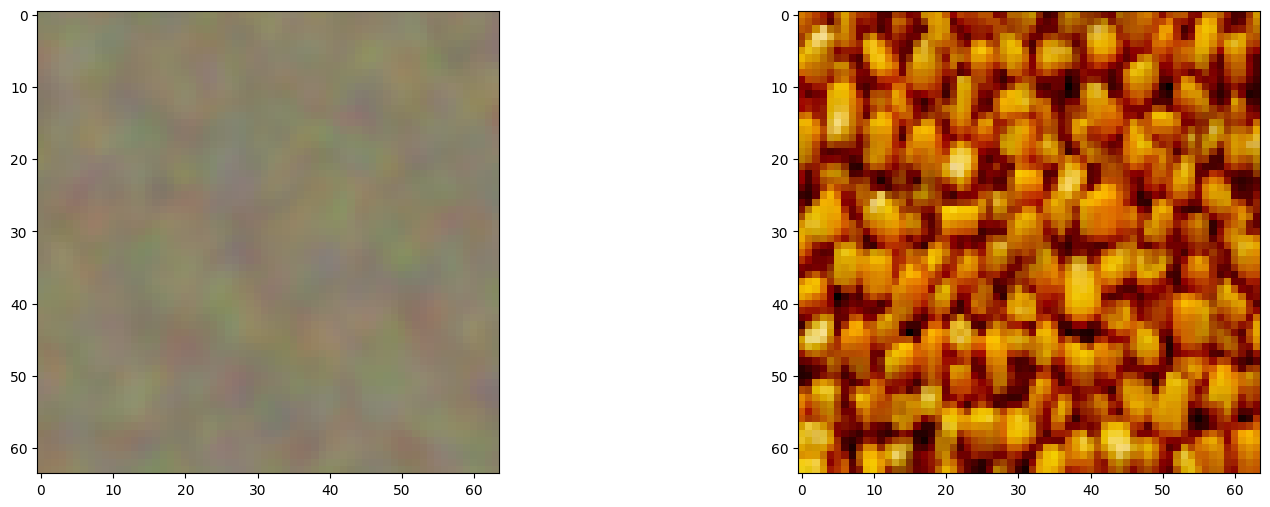

Step 100, Total loss 10.918763
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


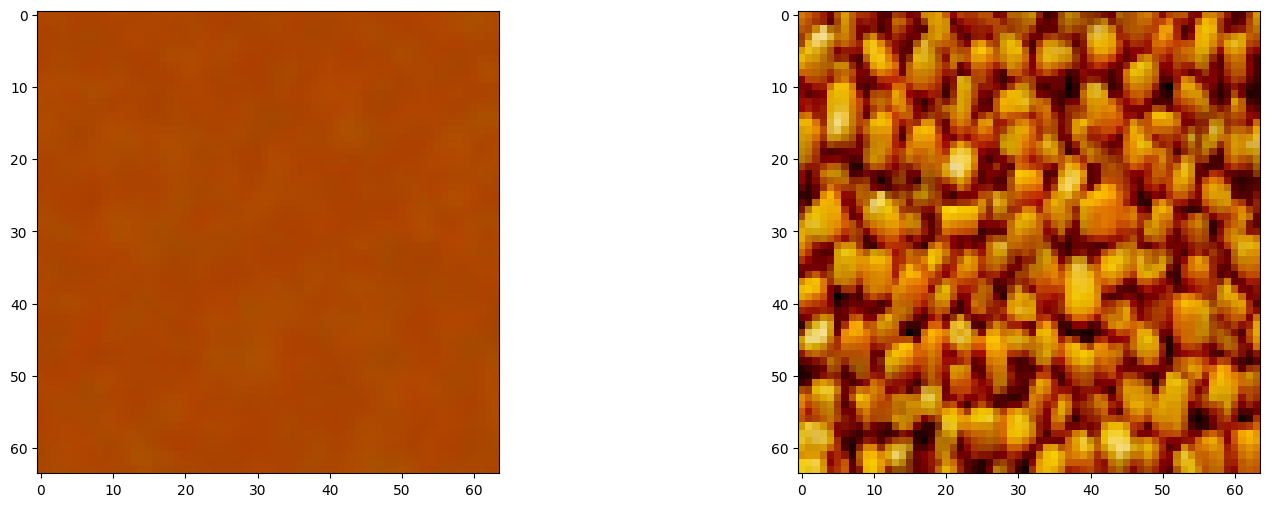

Step 200, Total loss 10.893532
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


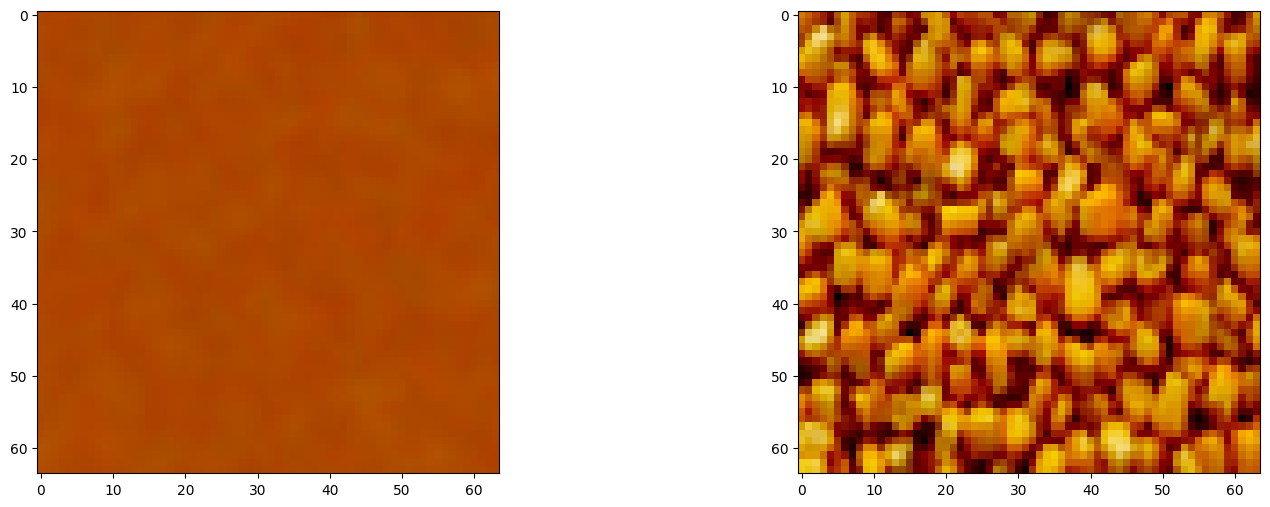

Step 300, Total loss 10.898111
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


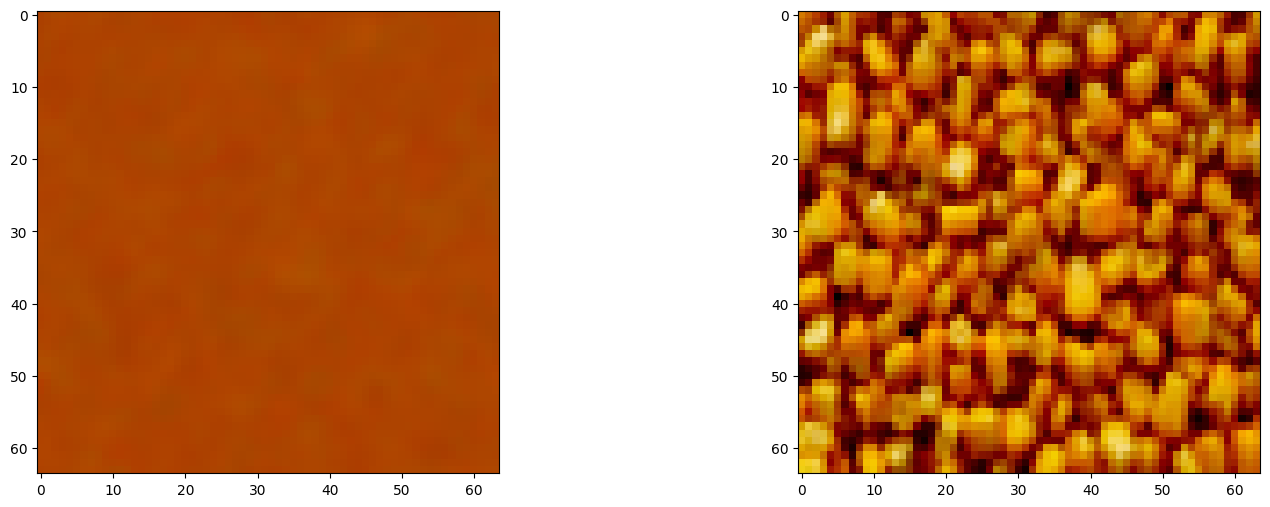

Step 400, Total loss 10.896054
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


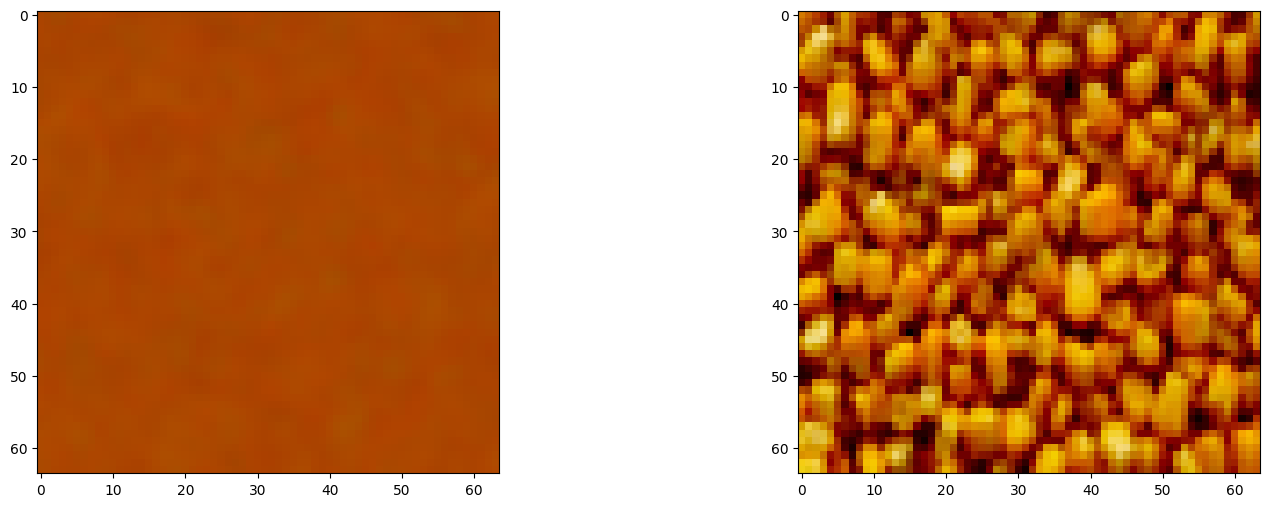

Step 500, Total loss 10.894301
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


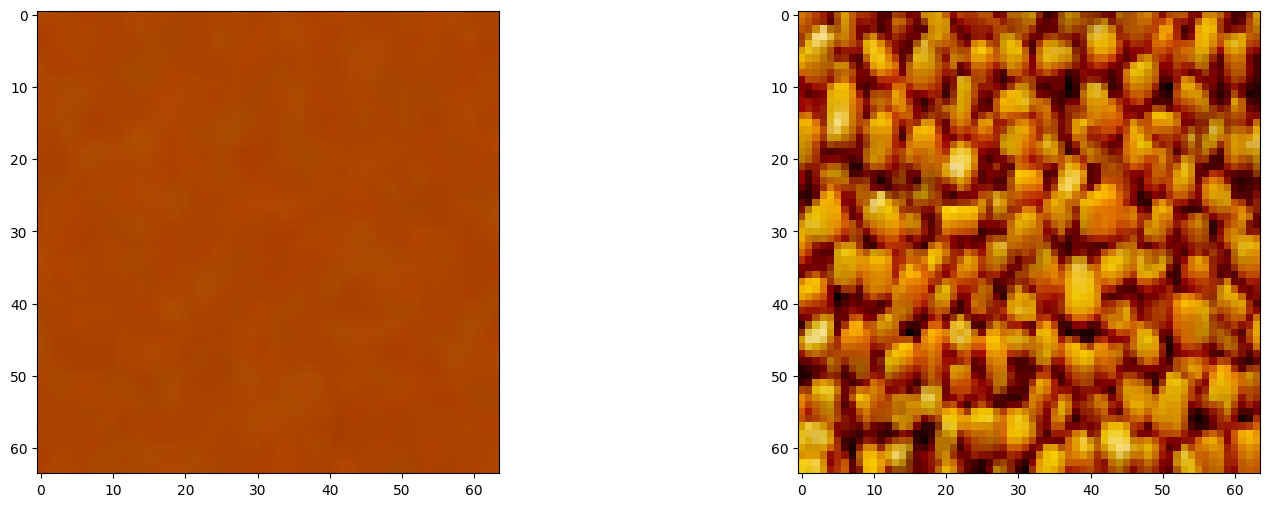

Step 600, Total loss 10.886156
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


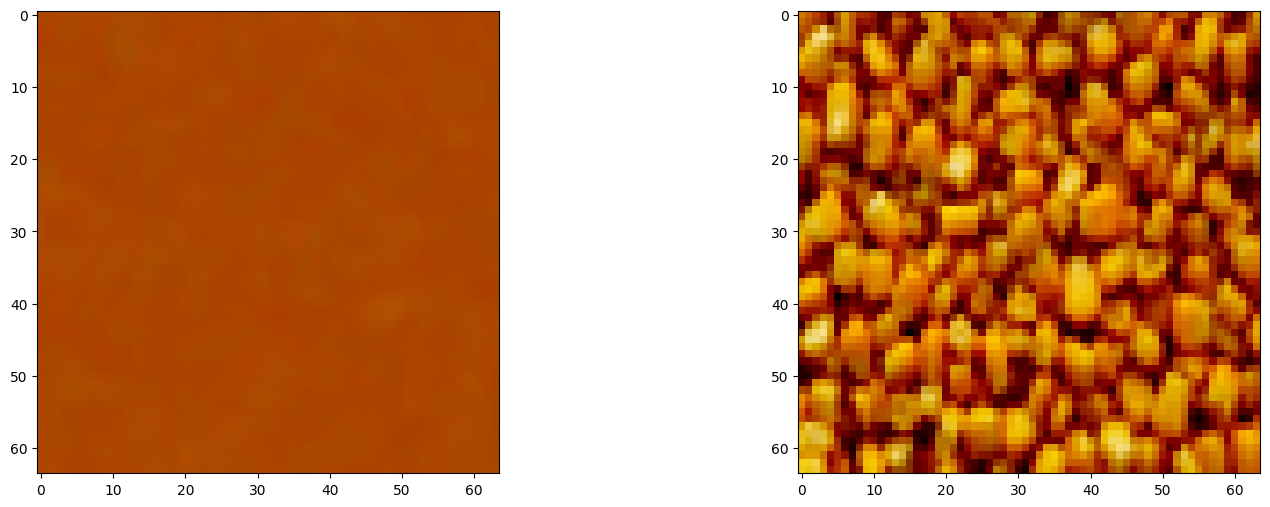

Step 700, Total loss 10.890892
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


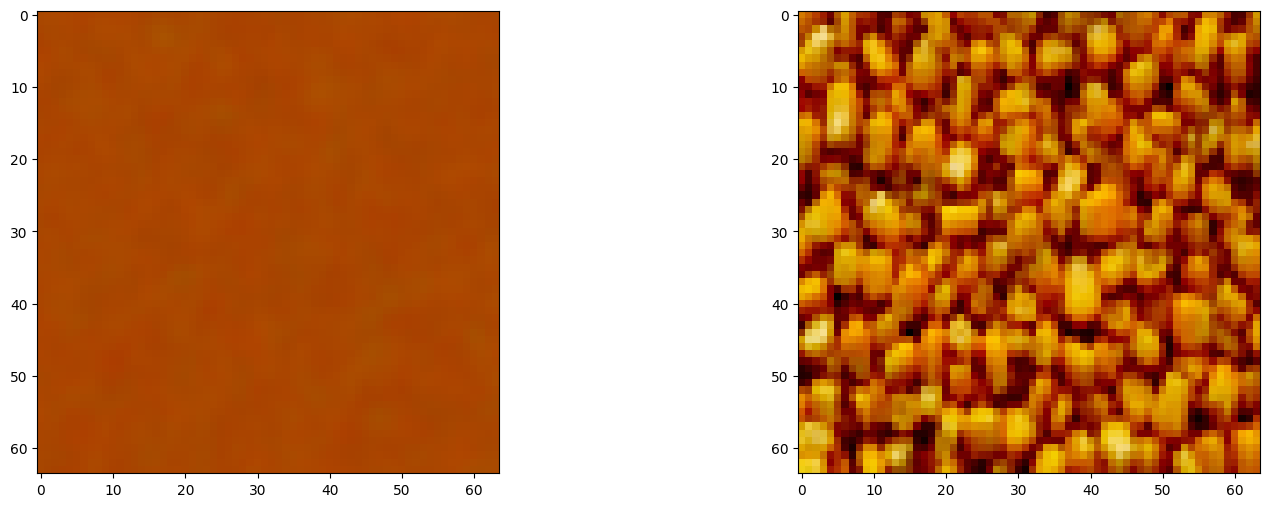

Step 800, Total loss 10.885157
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


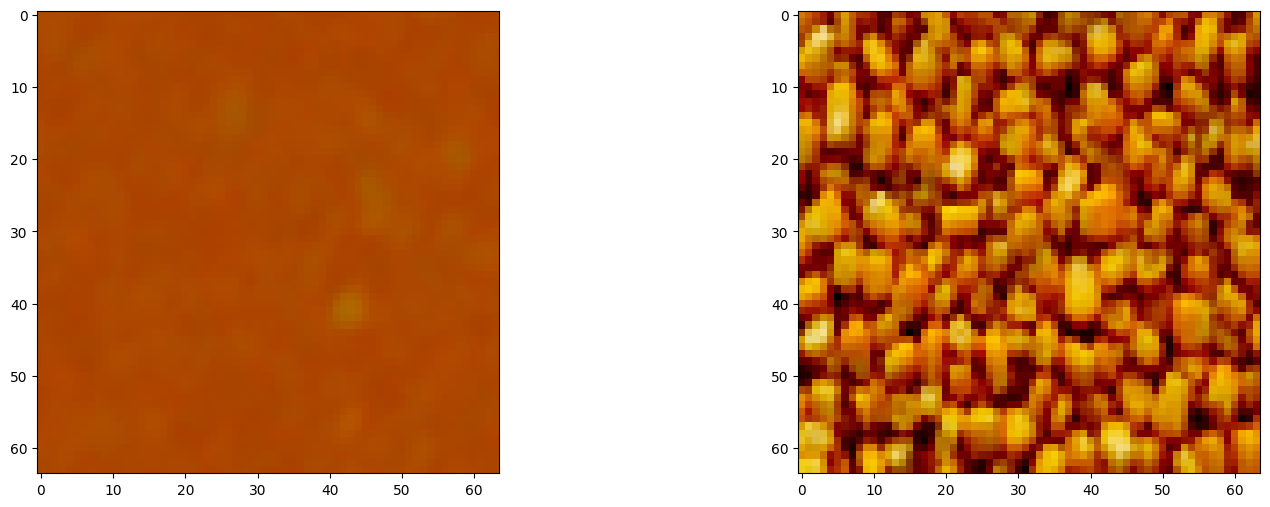

Step 900, Total loss 10.867190
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


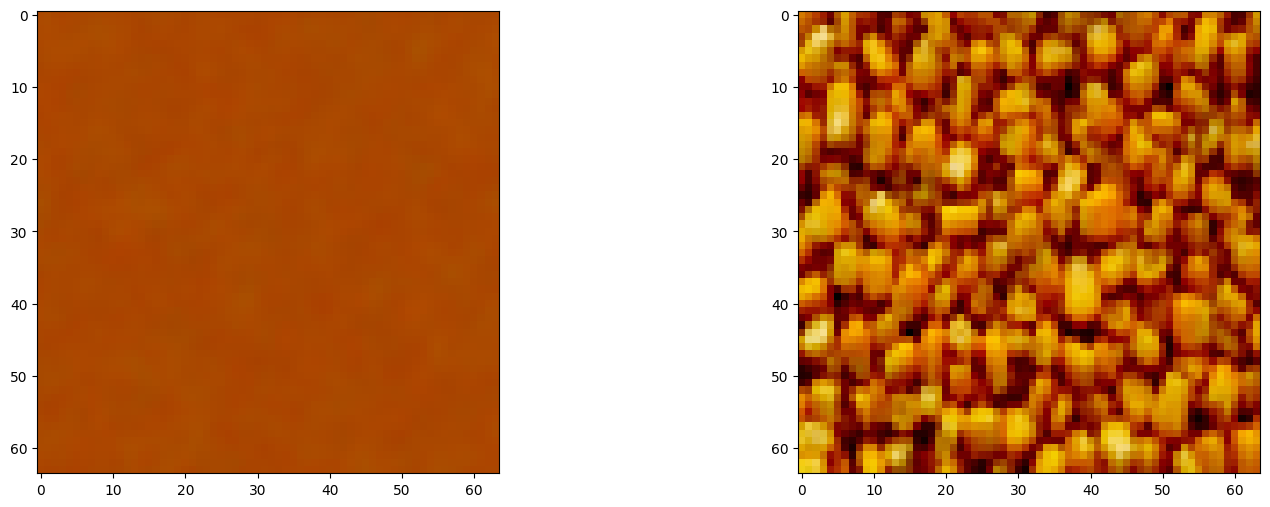

Step 1000, Total loss 10.866175
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


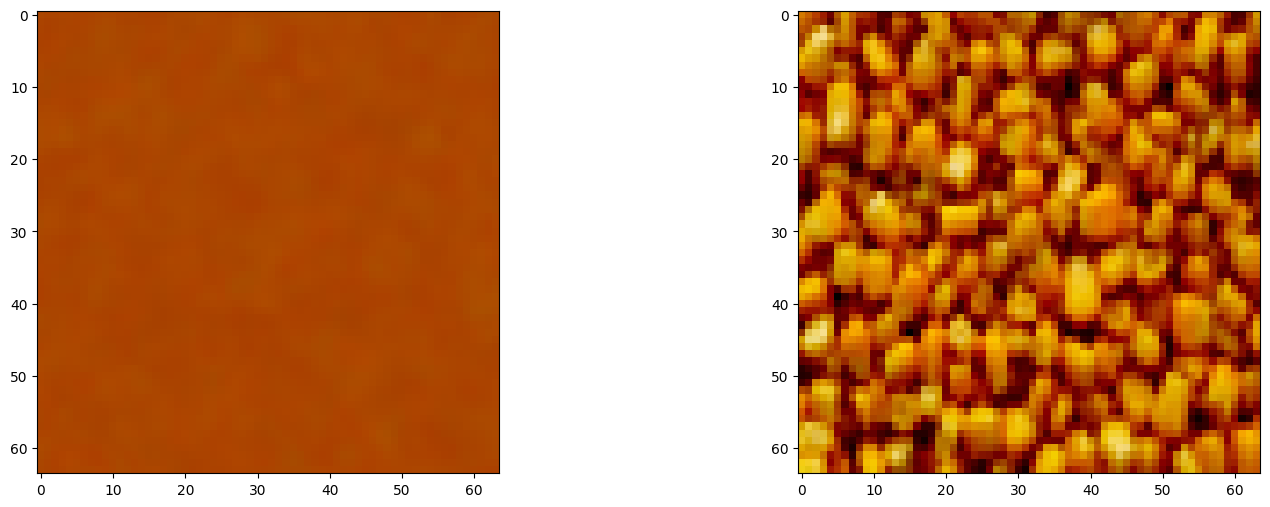

Step 1100, Total loss 10.881754
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


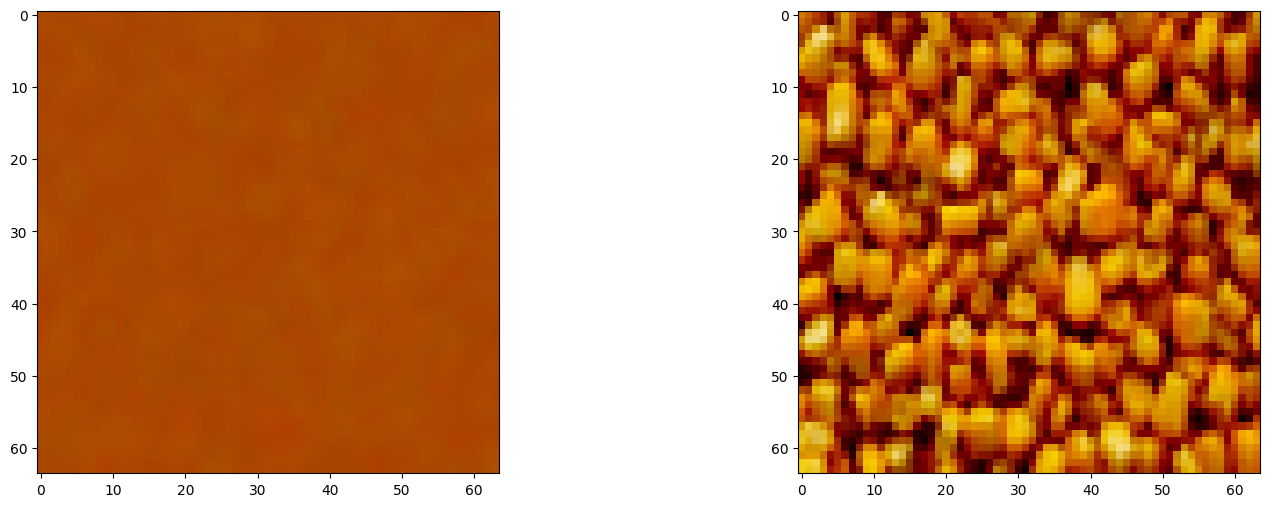

Step 1200, Total loss 10.884116
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


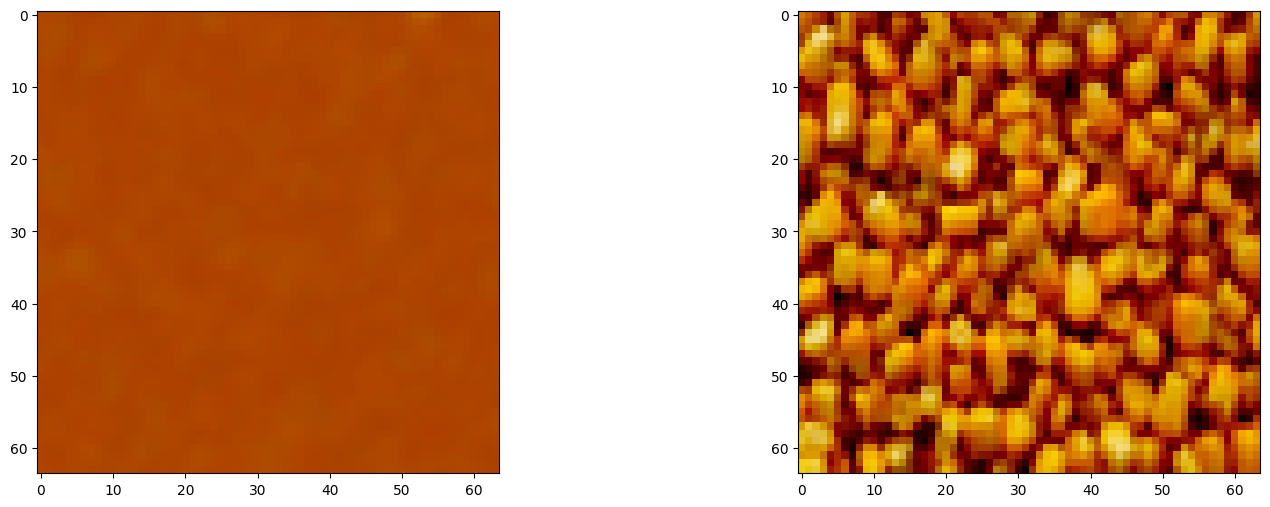

Step 1300, Total loss 10.877464
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


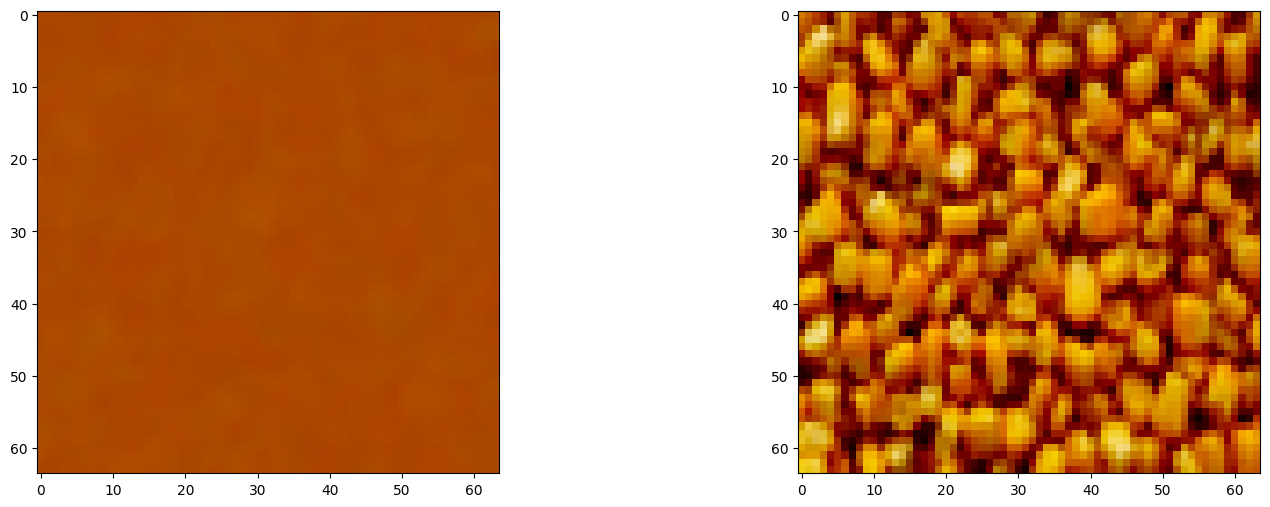

Step 1400, Total loss 10.853136
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


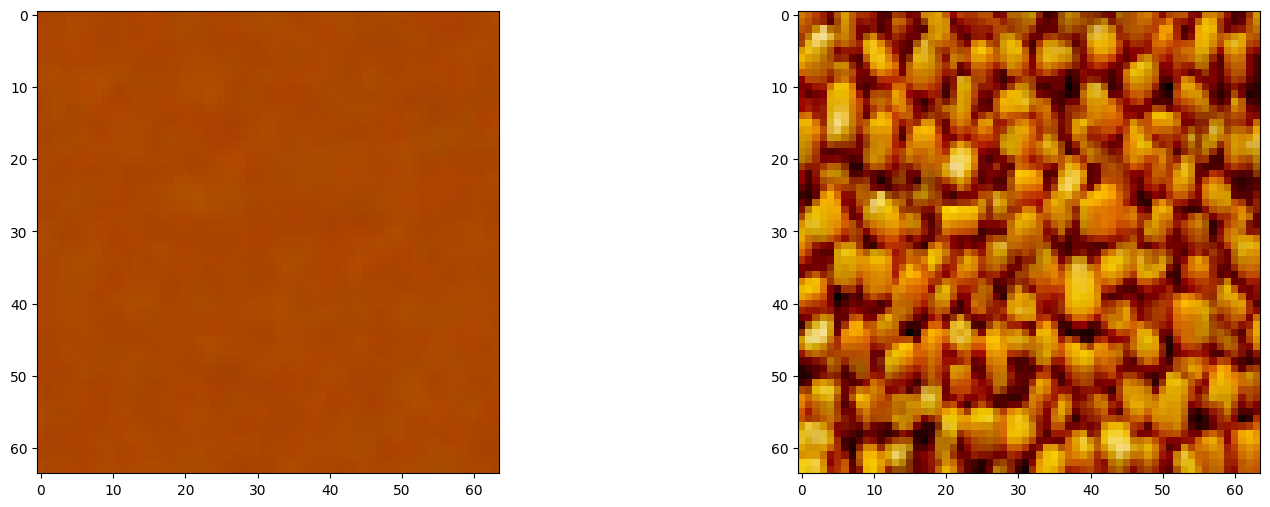

Step 1500, Total loss 10.899373
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


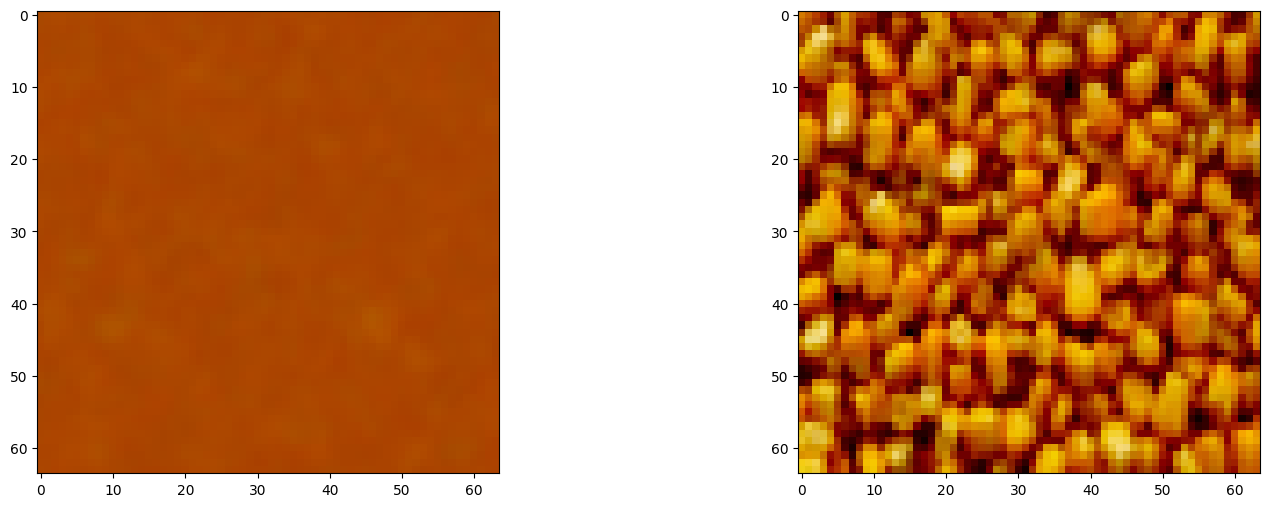

Step 1600, Total loss 10.870936
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


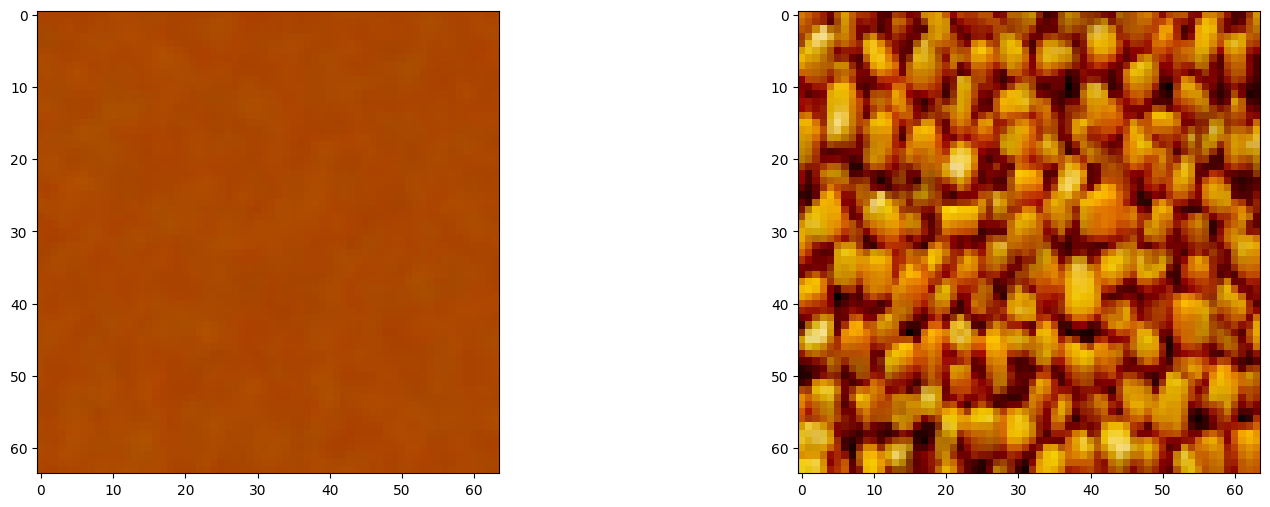

Step 1700, Total loss 10.981465
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


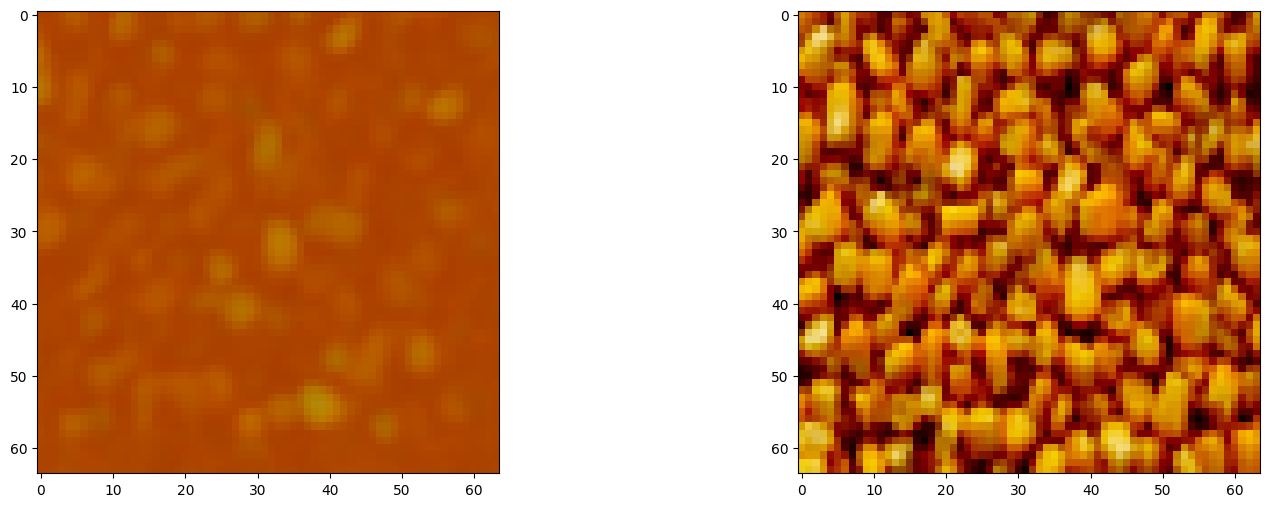

Step 1800, Total loss 10.876026
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


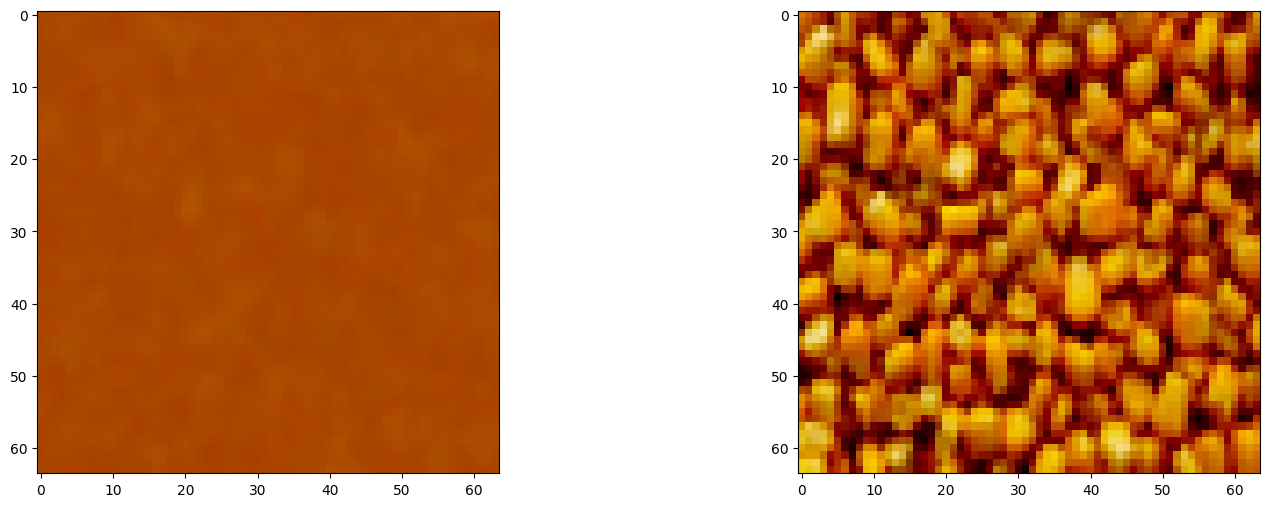

Step 1900, Total loss 10.867746
torch.Size([1, 64, 64, 3]) torch.Size([1, 64, 64, 3])


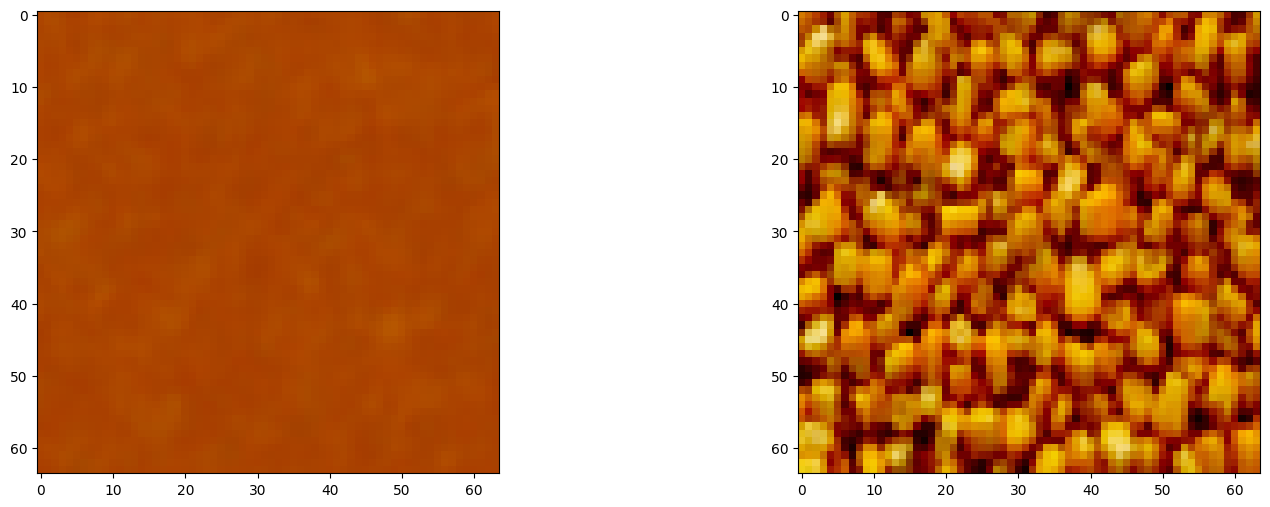

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, filename, sidelength, maxperiods):
        super().__init__()
        img = load_texture(filename, sidelength)
        print(img.shape)
        self.pixels = img.permute(1, 2, 0)#.reshape(-1, 3)
        self.coords = get_mgrid(sidelength, maxperiods, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        return self.coords, self.pixels

sidelength = 64
maxperiods = 1#0
filename = '/content/mais.jpg'
total_steps = 2000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 100
mlpwidth = 128


cameraman = ImageFitting(filename, sidelength, maxperiods)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=2, out_features=3, hidden_features=mlpwidth, hidden_layers=3, outermost_linear=True)
img_siren.cuda()
model_input, ground_truth = next(iter(dataloader))
ground_truth = ground_truth - 0.5
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
l1loss = nn.L1Loss()

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
for step in range(total_steps):
    model_output, coords = img_siren(model_input + 12.0 * torch.rand(1,1,1,2).cuda() - 6.0 )
    # loss = ((model_output - ground_truth)**2).mean()

    out = torch.fft.rfft2(model_output.view(sidelength,sidelength,3), s=None, dim=(- 3, - 2))
    gt = torch.fft.rfft2(ground_truth.view(sidelength,sidelength,3), s=None, dim=(- 3, - 2))
    # loss = (((out.real**2 + out.imag**2) - (gt.real**2 + gt.imag**2))**2 ).mean()
    # loss = ( torch.abs(out.real * gt.real + out.imag * gt.imag) ).mean() # / (gt.real**2 + gt.imag**2) ).mean()

    loss = l1loss(out, gt) #
    # loss += ((model_output - ground_truth)**2).mean()

    model_output2, coords2 = img_siren(model_input)
    loss += l1loss(model_output2, ground_truth) #((model_output2 - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # print(out.shape, gt.shape)
        print(model_output.shape, ground_truth.shape)
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,2, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(sidelength,sidelength,3).detach().numpy() + 0.5)
        axes[1].imshow(ground_truth.cpu().view(sidelength,sidelength,3).detach().numpy() + 0.5)
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

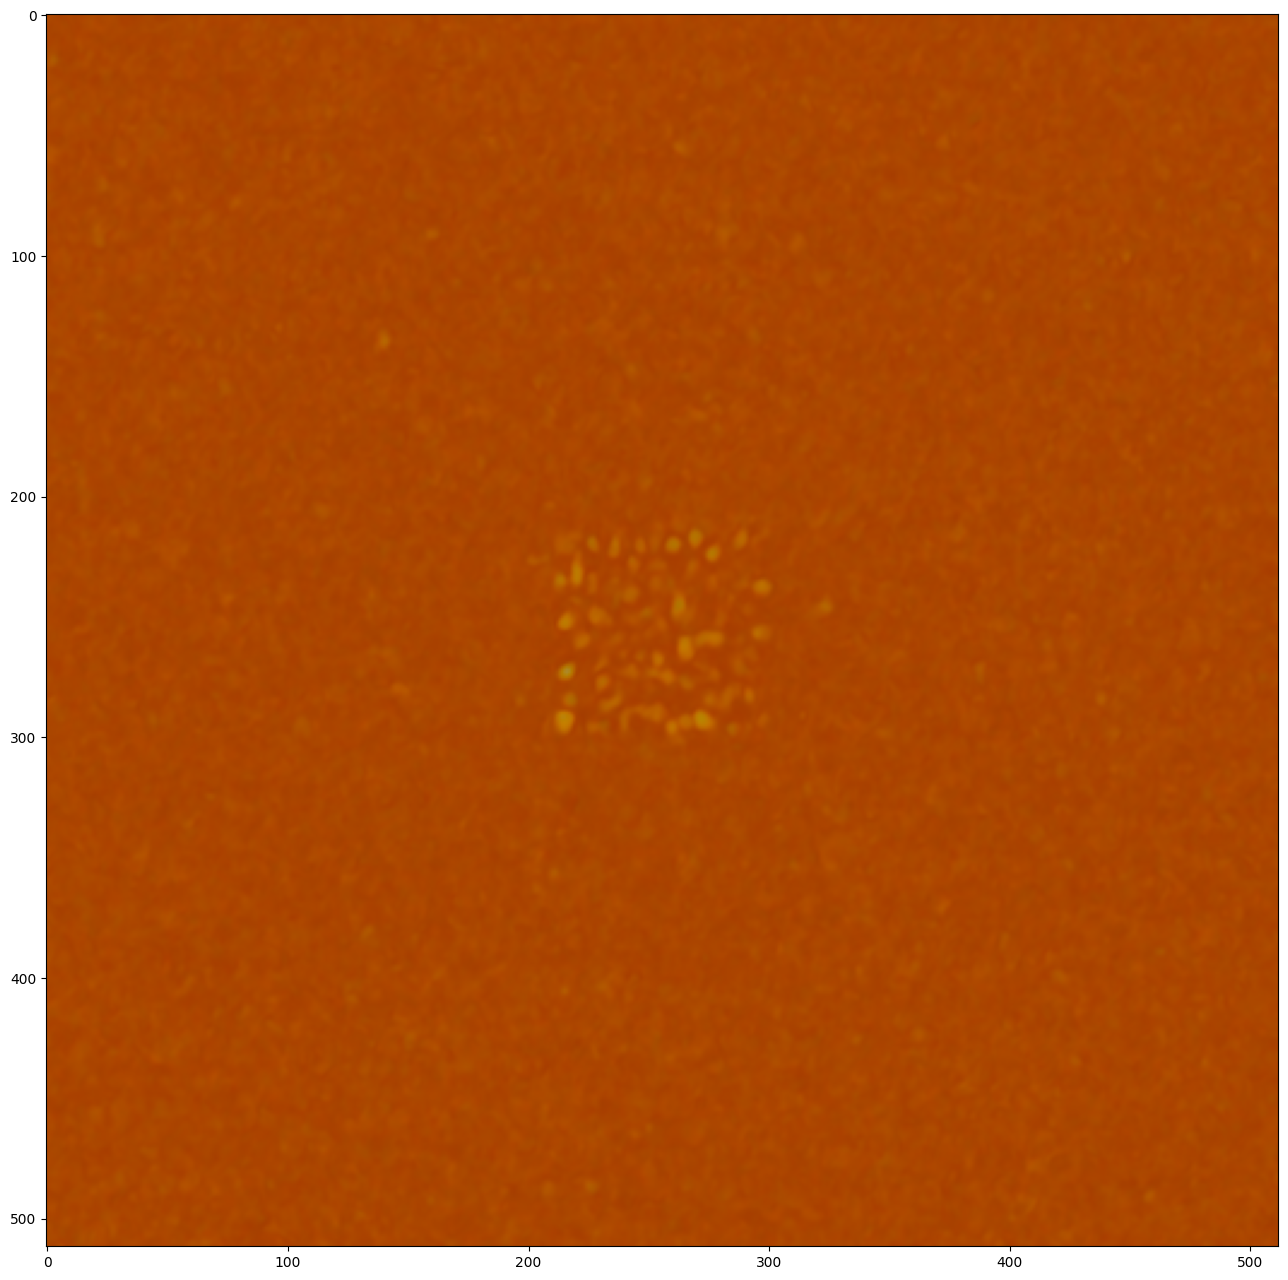

In [ ]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(512, 1, 2) * 6
    out_of_range_coords = out_of_range_coords.reshape(-1, 2)

    model_out, _ = img_siren(out_of_range_coords.cuda())

    fig, ax = plt.subplots(figsize=(16,16))
    ax.imshow(model_out.cpu().view(512,512,3).numpy()+0.5)
    plt.show()
